## FBM training (XGBoost) -- Loss curves (RMSE)

In [2]:
# Libraries
import os, glob, time, random, datetime, warnings
warnings.filterwarnings("ignore", category=FutureWarning) # ignore warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ML Models
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

# Scikit-Learn ML models to C++
# import m2cgen 

In [2]:
# Basic parameters
n_cores=4
n_trials=10
save=True

base_path = '/Users/minho/Desktop/Cell2FireML/Github/data'
out_basepath = '/Users/minho/Desktop/Cell2FireML/Github/plot/fbm_results'

In [24]:
def model_fit(ros_mode=None, fbm=None, n_cores=None, drop_var=[], n_trials=None, base_path=None, path=None):
    
    # Load input features and ROS outputs
    df = pd.read_csv(path)
    
    if fbm == 1: 
        label_encoder = LabelEncoder()
        encoded_feature = label_encoder.fit_transform(df['nftype'])
        df['nftype'] = encoded_feature                        
    if fbm == 2: 
        label_encoder = LabelEncoder()
        encoded_feature = label_encoder.fit_transform(df['nftype'])
        df['nftype'] = encoded_feature            
    if fbm == 3:
        # df = df.drop([df.keys()[0]], axis=1) # Unnamed first column
        df = df[['fueltype', 'ffmc', 'ws', 'bui', 'ps', 'saz', 'HROS', 'BROS', 'FROS']]
        label_encoder = LabelEncoder()
        encoded_feature = label_encoder.fit_transform(df['fueltype'])
        df['fueltype'] = encoded_feature

    # Select ROS mode (3-ROS vs 1-ROS output)
    ros_num = -3 if not ros_mode else -1
    print("3-ROS output" if not ros_mode else "Single ROS output with mode: ", ros_mode)

    if 'num' in df.columns:
        df = df.drop(columns = ['num'] + drop_var) 
    if ros_mode == "HROS" or ros_mode == "hros":
        df = df.drop(columns = ['BROS', 'FROS'])
    elif ros_mode == "BROS" or ros_mode == "bros":
        df = df.drop(columns = ['HROS', 'FROS'])
    elif ros_mode == "FROS" or ros_mode == "fros":
        df = df.drop(columns = ['BROS', 'HROS'])

    df = df.dropna().reset_index(drop=True)

    n_inputs = len(df.keys()[:ros_num]) # 1 ROS outputs
    X_train = df.iloc[:, :ros_num].values
    y_train = df.iloc[:,ros_num:]

    # Prepare data for ML
    train_features = np.array(X_train)
    train_labels = np.array(y_train).reshape((-1, ros_num*-1)) # 3ROS

    # Split to train and test 
    all_results, all_epochs = [], []
    seeds = []

    for trial in range(n_trials):
        seeds.append(trial)

        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.25, random_state=trial)

        # Set model
        model = XGBRegressor(max_depth=1000, n_jobs=n_cores, eval_metric=mse,early_stopping_round=10)

        # Fit model to predict and compute loss
        results = model.fit(train_features,train_labels, verbose=0,
                        eval_set=[(X_train, y_train), (X_test, y_test)])

        # Organize results in DF
        results_dict = results.evals_result()
        all_results.append(results_dict)
        all_epochs.append(np.arange(model.best_iteration + 1))

    return all_results, all_epochs

''' Prepare model training results for plotting in seaborn '''
def prepare_plot(all_results=None, all_epochs=None, set_name=None, loss_name=None):

    loss_list = [all_results[i][set_name][loss_name] for i in range(len(all_results))]
    epochs_list = [all_epochs[i] for i in range(len(all_epochs))]

    df_train_rmse = pd.DataFrame({'loss': loss_list, 'epochs': epochs_list})

    data = []
    # Iterate over each row in the DataFrame
    for index, row in df_train_rmse.iterrows():
        # Zip the epochs and loss lists together and append them to the data list
        data.extend(zip(row['epochs'], row['loss']))

    # Create a new DataFrame from the data list with columns 'epoch' and 'loss'
    new_df = pd.DataFrame(data, columns=['epoch', 'loss'])

    return new_df

''' Plot all trials as line plot '''
def plot_loss_curves(df_train=None, df_test=None, thresh=0, ros_mode=None, loss_name=None, save=False, output_path=None):
    fig, ax = plt.subplots(figsize=(9, 6))

    sns.lineplot(df_train, x ='epoch', y='loss', color='k', label='Train', ax=ax)
    sns.lineplot(df_test, x ='epoch', y='loss', color='r', label='Test', ax=ax)

    ax.set_xlabel('Epochs', size=14)
    ax.set_ylabel('Loss ({})'.format(loss_name), size=14)
    ax.set_title(ros_mode, size=18)
    ax.legend(loc='upper left')

    # Inset plot
    inset_ax = ax.inset_axes([0.65, 0.6, 0.3, 0.3])
    sns.lineplot(df_train, x ='epoch', y='loss', color='k', label='Train', ax=inset_ax)
    sns.lineplot(df_test, x ='epoch', y='loss', color='r', label='Test', ax=inset_ax)
    inset_ax.set_ylabel('Loss ({})'.format(loss_name), size=10) 
    inset_ax.set_xlabel('')
    inset_ax.set_ylim([0,0.01])
    inset_ax.set_title('Close-up plot', size=10)
    
    # Inset plot2
    df_train['diff'] = df_train['loss'] - df_test['loss']
    
    inset_ax2 = ax.inset_axes([0.65, 0.2, 0.3, 0.3])
    # inset_ax2 = inset_axes(ax, width="30%", height="30%", borderpad=3, loc='upper right')
    sns.lineplot(x=df_train[thresh:]['epoch'], y=df_train[thresh:]['diff'], color='k', label='Difference', legend=False, ax=inset_ax2)
    inset_ax2.set_ylabel('$Loss_{train}$ - $Loss_{test}$', size=10) 
    inset_ax2.set_xlabel('Epochs', size=10)
    inset_ax2.set_xlim(df_train['epoch'][thresh], df_train['epoch'].iloc[-1])
    inset_ax2.set_title('Difference in train and test loss', size=10)

    if save:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

## US (BehavePlus v6)

In [25]:
# US (BP6) Parameters
fbm=1
region='us'
drop_var=[]
path = os.path.join(base_path, 'bp6_training_data.csv')

Single ROS output with mode:  HROS
[22:11:39] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:12:03] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:12:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:12:51] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:13:16] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:13:40] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:14:04] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:14:29] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:14:53] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[22:15:18] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

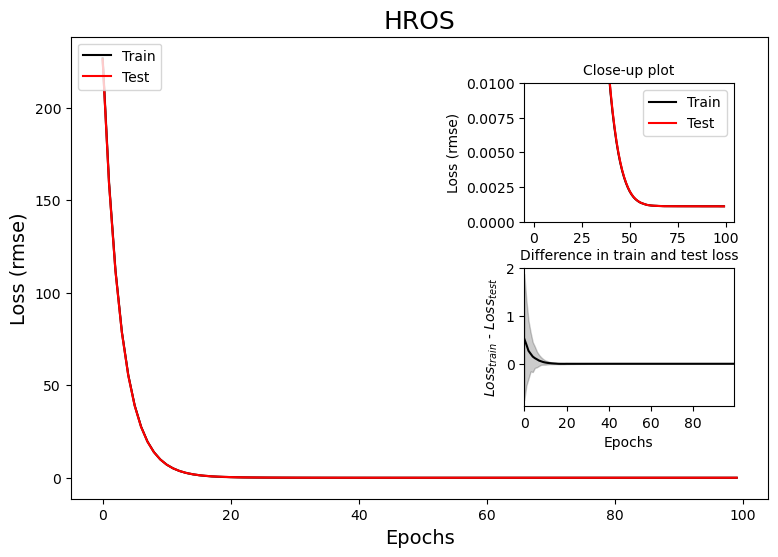

In [26]:
# 1. HROS
ros_mode = 'HROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=True, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  BROS
[21:36:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:36:51] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:36:55] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:36:59] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:04] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:10] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:16] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:20] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:25] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:29] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

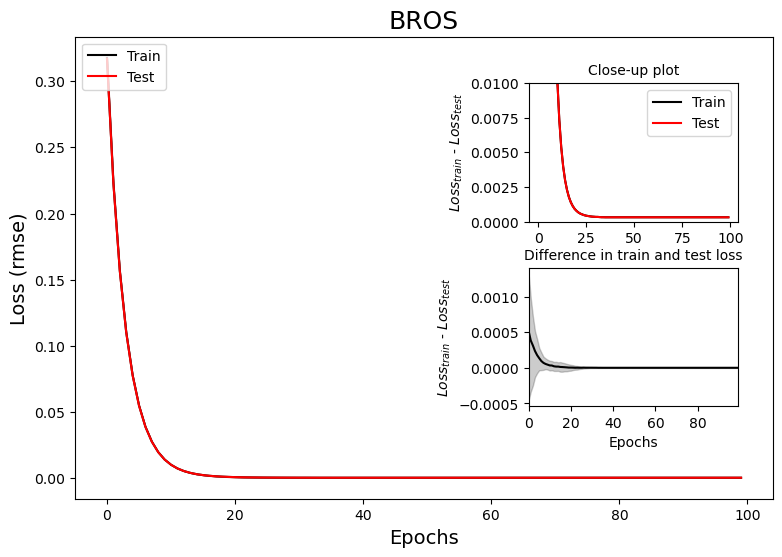

In [14]:
# 2. BROS
ros_mode = 'BROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  FROS
[21:37:41] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:49] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:37:56] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:04] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:11] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:19] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:34] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:41] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:38:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

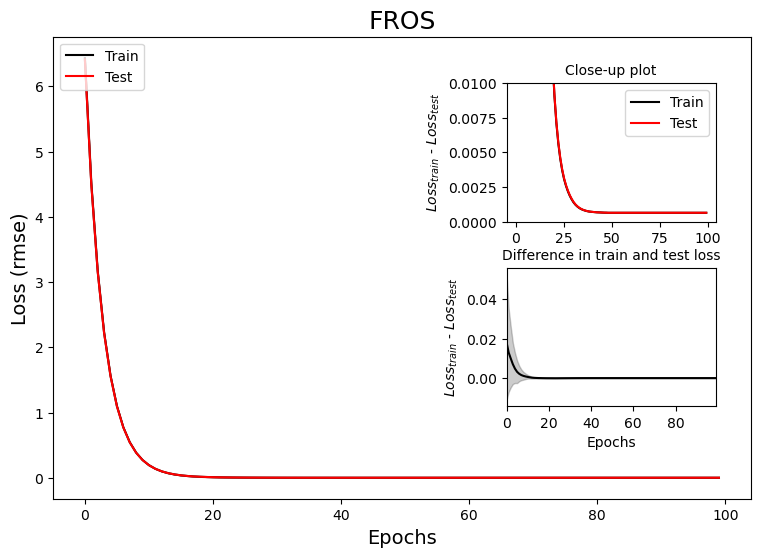

In [15]:
# 3. FROS
ros_mode = 'FROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

## Canada (FBP)

In [16]:
# Canada (FBP) Parameters
fbm=3
region='canada'
drop_var=[]
path = os.path.join(base_path, 'fbp_training_data.csv')

Single ROS output with mode:  HROS
[21:39:03] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:39:15] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:39:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:39:39] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:39:51] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:40:03] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:40:15] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:40:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:40:39] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:40:51] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

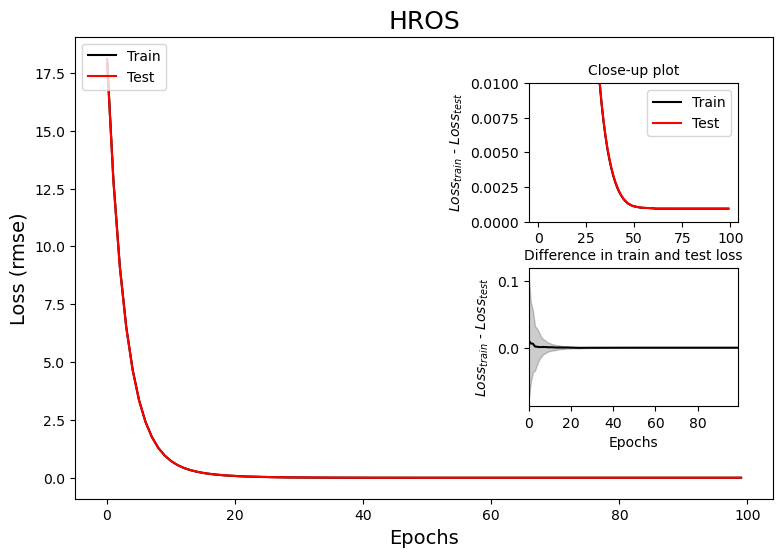

In [17]:
# 1. HROS
ros_mode = 'HROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  BROS
[21:41:11] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:15] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:25] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:29] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:34] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:39] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:43] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:41:53] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

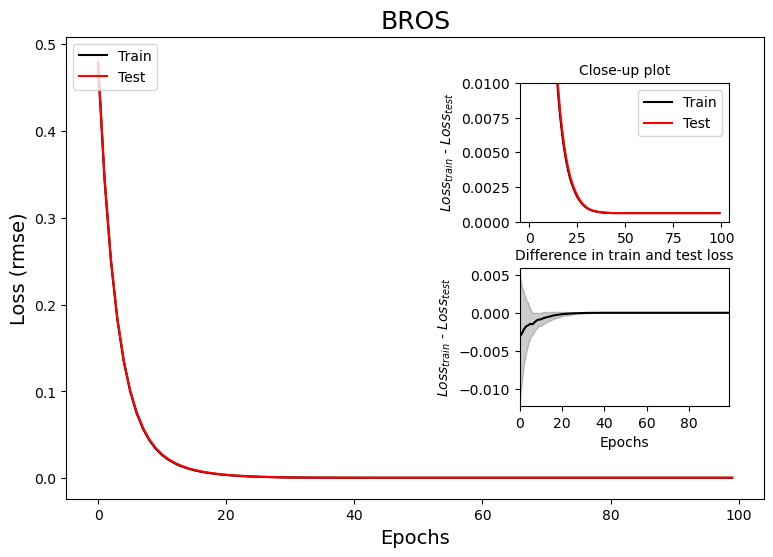

In [18]:
# 2. BROS
ros_mode = 'BROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  FROS
[21:42:05] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:13] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:20] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:34] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:41] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:42:56] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:03] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:10] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

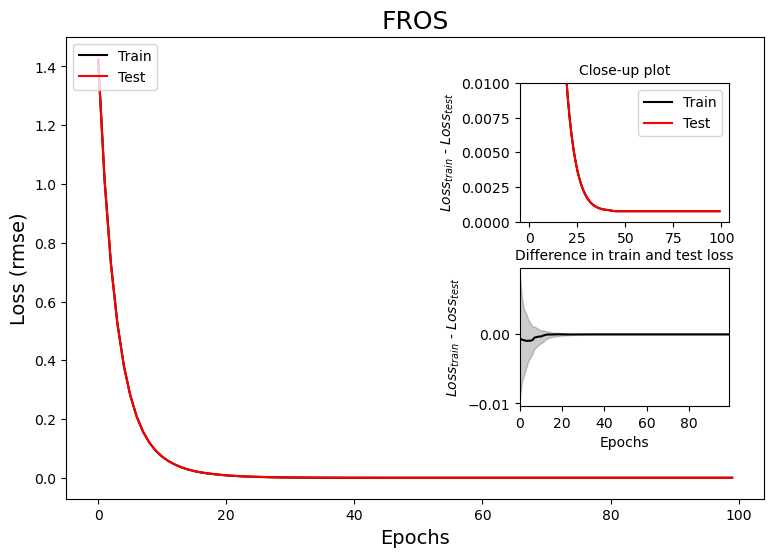

In [19]:
# 3. FROS
ros_mode = 'FROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

## Chile (KITRAL)

In [20]:
# Chile (KITRAL) Parameters
fbm=2
region='chile'
drop_var=[]
path = os.path.join(base_path, 'kitral_training_data.csv')

Single ROS output with mode:  HROS
[21:43:49] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:51] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:53] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:55] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:56] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:43:58] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:00] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:02] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:04] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:05] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

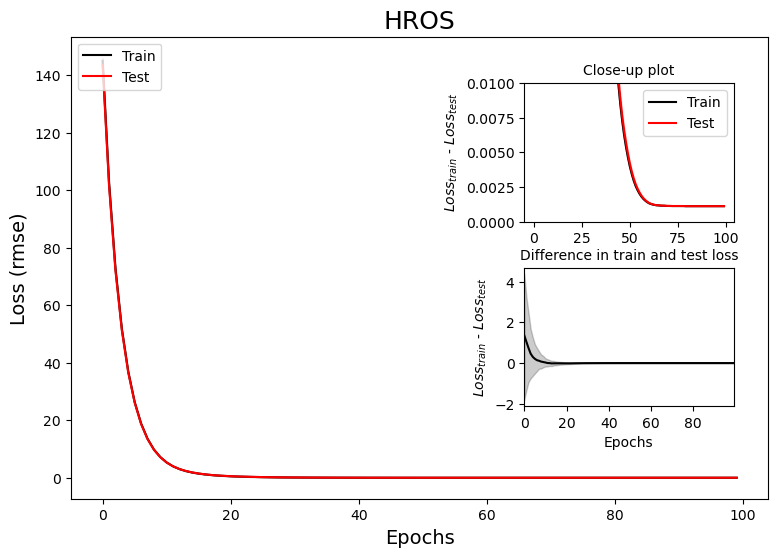

In [21]:
# 1. HROS
ros_mode = 'HROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  BROS
[21:44:15] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:15] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:16] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:16] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:17] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:17] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:18] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:18] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:19] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:19] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

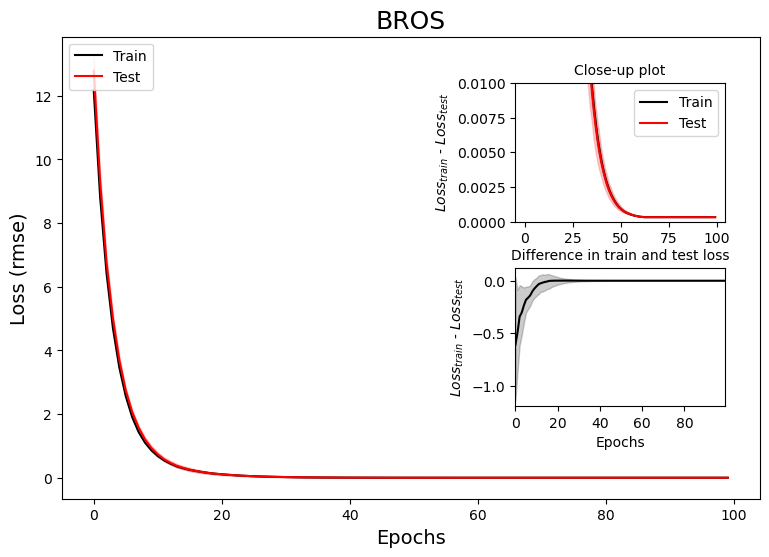

In [22]:
# 2. BROS
ros_mode = 'BROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))

Single ROS output with mode:  FROS
[21:44:27] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:28] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:28] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:29] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:29] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:30] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:31] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:31] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:32] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } are not used.

[21:44:32] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round" } 

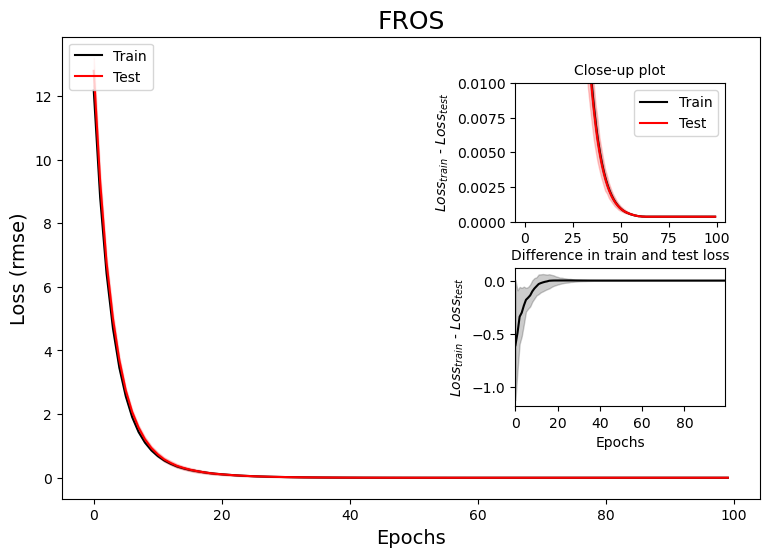

In [23]:
# 3. FROS
ros_mode = 'FROS'
loss_name = 'rmse'

# Fit
all_results, all_epochs = model_fit(ros_mode=ros_mode, fbm=fbm, n_cores=n_cores, drop_var=drop_var, n_trials=n_trials, base_path=base_path, path=path)

# Prepare data
df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name=loss_name) # Train
df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name=loss_name)  # Test

# Plot visualizations
plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name=loss_name, save=save, output_path=os.path.join(out_basepath, ros_mode + '_' + region + '_xgboost.png'))